In [1]:
from Pinns_Class import *
import matplotlib.pyplot as plt

Running on  cpu


### Cos_1D

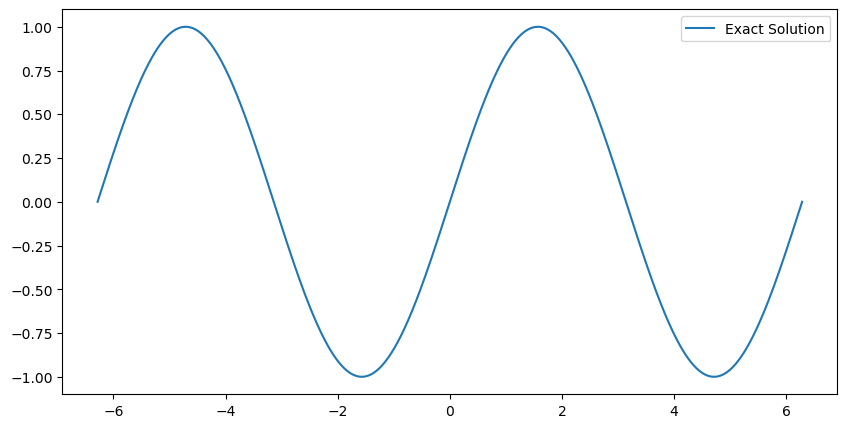

In [2]:
domain_extrema = [-2*torch.pi, 2*torch.pi]
w = 1
n_hidden_layers = 2
neurons = 16
activation_function = nn.Tanh()

# Create the model
model = Cos_1D(domain_extrema, w, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE, requires_grad=True).reshape(-1, 1)   # the input has to be of shape (n, 1)
u_exact = model.exact_solution(x_test)

fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact Solution')
plt.legend()

Final loss:  0.03846263140439987 	 Training_time:  0  min  1  s


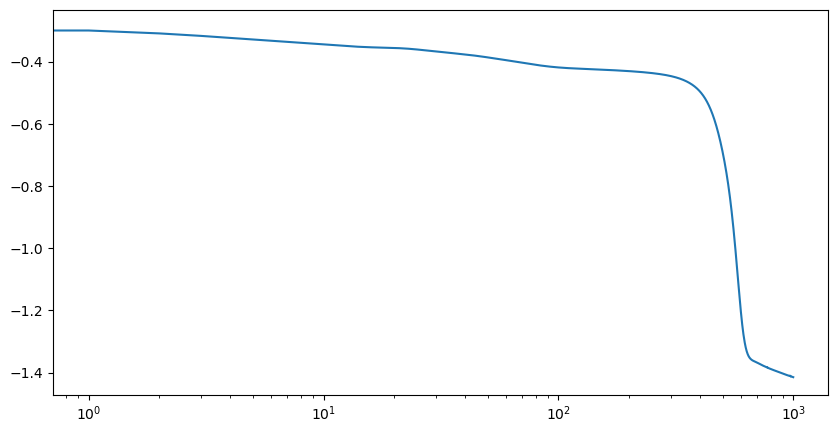

In [3]:
num_points = 200
n_epochs = 1000
optimizer_ADAM = optim.Adam(model.parameters(),
                            lr=float(0.001))
history = model.fit(num_points, optimizer_ADAM, n_epochs, verbose=False)

# Plot the loss
fig = plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs),np.log10(history), label='Loss')
plt.xscale('log')

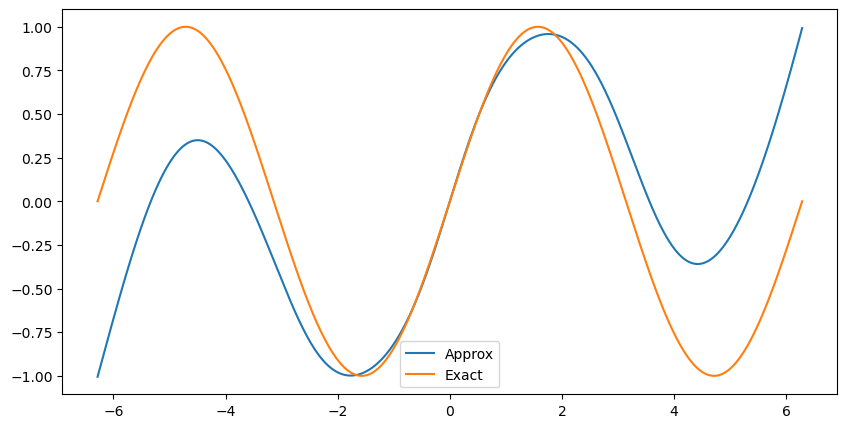

In [4]:
model.eval()
# u_approx = model(x_test)
u_exact = model.exact_solution(x_test)
# Approximate the solution with the NN building the ansatz
# u_approx = torch.tanh(model.w * model.normalize_input(x_test)) * model.unnormalize_output( model( model.normalize_input( x_test)) )
u_approx = torch.tanh(model.w * x_test) * model.unnormalize_output( model( model.normalize_input( x_test)) )


fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), label='Approx')
plt.plot(x_test.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact')
plt.legend()

### Cos_muldi1D

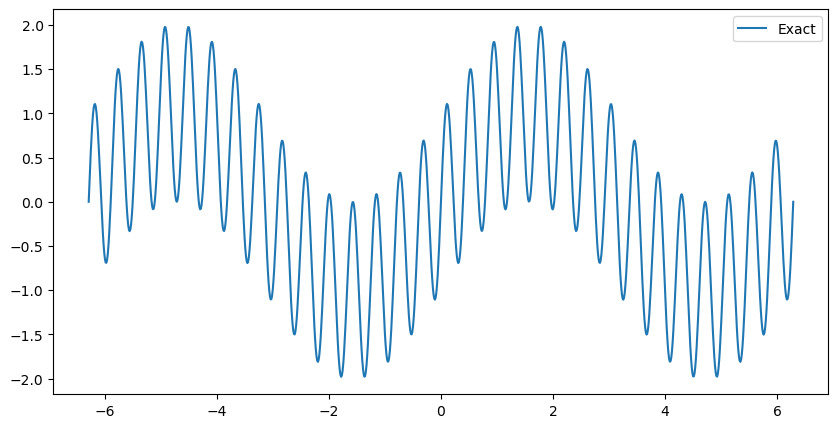

In [3]:
n_multi_scale = 2
w_list = [1, 15]
n_hidden_layers = 3
neurons = 20
activation_function = nn.Tanh()

# Create the model
model = PINN(n_multi_scale, w_list, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE)
u_exact = model.exact_solution(x_test)

fig = plt.figure(figsize=(10, 5))
plt.plot(x_test.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
plt.legend()

In [4]:
n_multi_scale = 1
w_list = [5]
n_hidden_layers = 3
neurons = 20
activation_function = nn.Tanh()

# Create the model
model = PINN(n_multi_scale, w_list, n_hidden_layers, neurons, activation_function)

# Test the exact solution
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 1000, dtype=torch.float32, device=DEVICE)
x_norm = model.normalize(x_test)
u_exact = model.exact_solution(x_test)
u_sol = torch.sin(x_test*w_list[0])

fig = plt.figure(figsize=(10, 5))
plt.plot(x_norm.cpu().numpy(), u_exact.cpu().numpy(), label='Exact')
plt.plot(x_norm.cpu().numpy(), u_sol.cpu().numpy(), label='Solution')
plt.legend()

AttributeError: 'PINN' object has no attribute 'normalize'

In [ ]:
torch.tanh(torch.tensor([1]))

tensor([0.7616])

In [ ]:
x_test = torch.linspace(-2*torch.pi, 2*torch.pi, 8, dtype=torch.float32, device=DEVICE)
print(x_test)

x_norm = model.normalize(x_test)
print(x_norm)

x_norm2 = model.normalize(x_norm)
print(x_norm2)

tensor([-6.2832, -4.4880, -2.6928, -0.8976,  0.8976,  2.6928,  4.4880,  6.2832])
tensor([-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000])
tensor([-1.0000, -0.7143, -0.4286, -0.1429,  0.1429,  0.4286,  0.7143,  1.0000])


### Test Domain Decomposition and Window fct

In [2]:
# Parameters
domain = [-2*torch.pi, 2*torch.pi]
w = 1
n_subdomains = 5
overlap = 1.3
sigma = 0.1
n_hidden_layers = 2
neurons = 16

# Create the model
fbpinn = FBPINN(domain_extrema=domain, n_subdomains=n_subdomains, overlap=overlap, sigma=sigma, n_hidden_layers=n_hidden_layers, neurons=neurons, activation_function=nn.Tanh(), PINN_class=Cos_1D, w=w)

# # Create the subdomains
# fbpinn.make_subdomains()

(-0.1, 20.0)

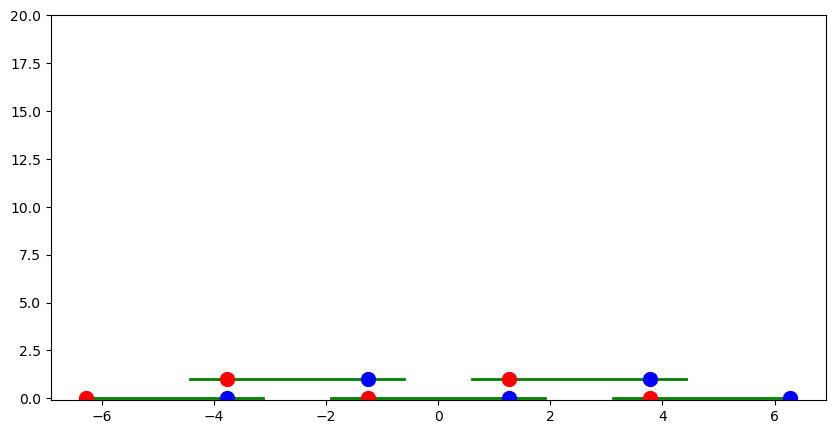

In [3]:
# plot the subdomains
subdomains = fbpinn.subdomains
midpoints = fbpinn.midpoints_overlap

fig = plt.figure(figsize=(10, 5))
for i in range(fbpinn.n_subdomains):
    x = np.linspace(subdomains[i][0], subdomains[i][1], 100)
    y = np.full(100, i%2)
    plt.plot(x, y, color='green', linewidth=2)
    plt.plot(midpoints[i][0], y[0], 'o', color='red', markersize=10)
    plt.plot(midpoints[i][1], y[0], 'o', color='blue', markersize=10)
plt.ylim(-0.1, 20)


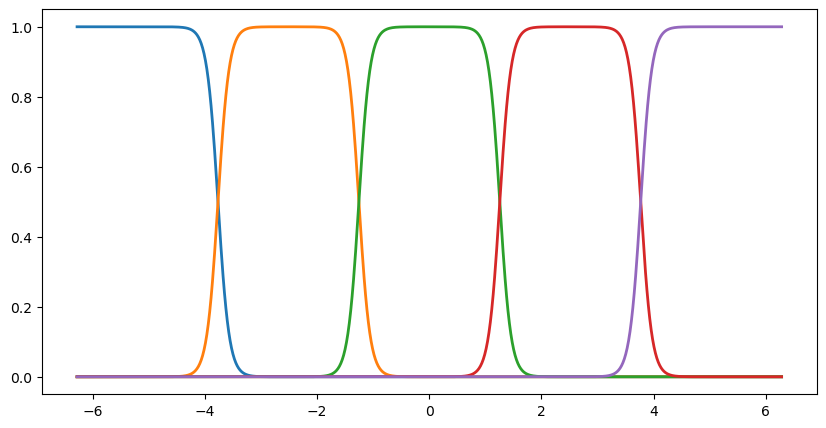

In [4]:
# plot the window functions
window_fct = []
x = np.linspace(domain[0], domain[1], 1000)
for i in range(fbpinn.n_subdomains):
    window_fct.append(fbpinn.window_function(x, midpoints[i][0], midpoints[i][1]))

fig = plt.figure(figsize=(10, 5))
for i in range(fbpinn.n_subdomains):
    plt.plot(x, window_fct[i], linewidth=2)

Final loss:  1.5510515368077904e-05 	 Training_time:  2  min  32  s


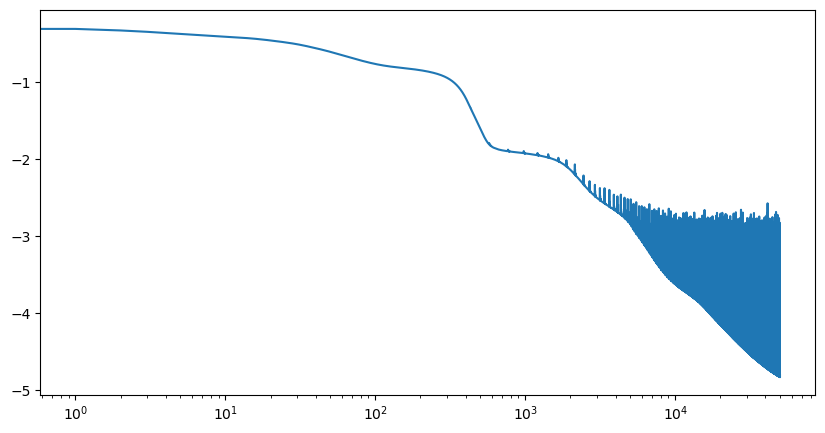

In [5]:
# Train the FBPINN
num_points = 200
n_epochs = 50000

history = fbpinn.fit(num_points, n_epochs, verbose=False)

# Plot the loss
fig = plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs),np.log10(history), label='Loss')
plt.xscale('log')

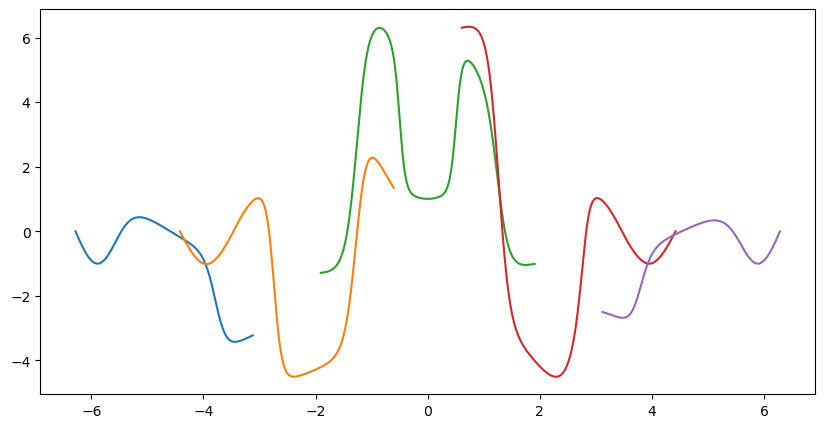

In [6]:
# Plot the approximation
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig = plt.figure(figsize=(10, 5))

for i in range(fbpinn.n_subdomains):
    subdomain_i = fbpinn.subdomains[i]
    NN_i = fbpinn.neural_networks[i]
    NN_i.eval()
    
    x_test = torch.linspace(subdomain_i[0], subdomain_i[1], num_points, dtype=torch.float32, device=DEVICE).reshape(-1, 1)
    
    # u_exact = NN_i.exact_solution(x_test)
    u_approx = fbpinn(x_test)

    plt.plot(x_test.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), label=f'Approx {i}')
    # axes[(i//3), (i%3)].plot(x_test.cpu().detach().numpy(), u_exact.cpu().detach().numpy(), label='Exact')
    # axes[(i//3), (i%3)].plot(x_test.cpu().detach().numpy(), u_approx.cpu().detach().numpy(), label='Approx')

    # axes[(i//3), (i%3)].set_title(f'Subdomain {i}')
    # axes[(i//3), (i%3)].legend()